## Import Libraries

In [ ]:
#%pip install yfinance matplotlib pandas deap

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calendar
import random
import time
from deap import base, creator, tools, algorithms

plt.style.use("dark_background")

## Download Data

### Define Stock Symbol and Date Range

In [3]:
symbol = "^GSPC"
start_date = "1990-01-01"
end_date = "2024-12-31"
train_cutoff_date = "2019-12-31"

### Download Historical Price Data

In [4]:
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = df.columns.get_level_values(0)
df = df[['Close']]
df.head()

C:\Users\Brian\AppData\Local\Temp\ipykernel_5900\1241090399.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close
Date,
1990-01-02,359.690002
1990-01-03,358.760010
1990-01-04,355.670013
1990-01-05,352.200012
1990-01-08,353.790009


### Plot Historical Closing Price

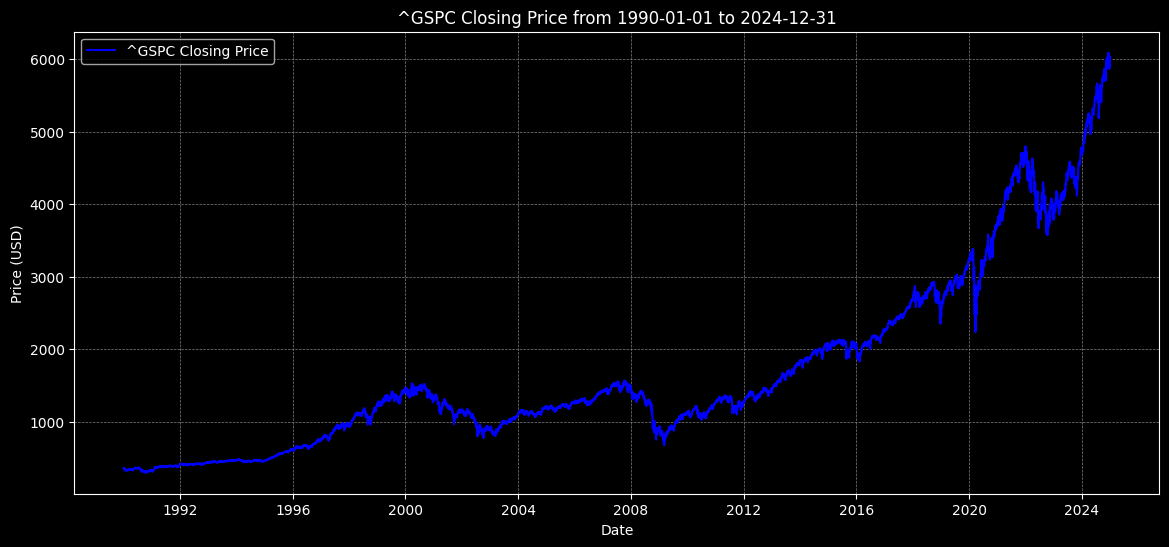

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label=f"{symbol} Closing Price", color='blue')
plt.title(f"{symbol} Closing Price from {start_date} to {end_date}")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.savefig("closing_price_plot.png", dpi=300, bbox_inches='tight')
plt.show()

## Split Data into Training and Testing Sets

In [6]:
df_train = df.loc[start_date:train_cutoff_date].copy()
df_test = df.loc[train_cutoff_date:end_date].copy()

print("Training range:", start_date, "to", train_cutoff_date)
print("Testing range:", train_cutoff_date, "to", end_date)

Training range: 1990-01-01 to 2019-12-31
Testing range: 2019-12-31 to 2024-12-31


## Define Single Moving Average Crossover Backtesting Strategy

In [7]:
def backtest_strategy_double_ma(data, short_window, long_window, initial_capital):
    df = data.copy()

    # Compute short and long moving averages
    df['SMA_Short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_Long'] = df['Close'].rolling(window=long_window).mean()

    # Generate buy signal when short MA crosses above long MA
    df['Signal'] = 0
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Signal'] = 1

    # Lag position by 1 day
    df['Position'] = df['Signal'].shift(1)

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()
    df['Strategy Return'] = df['Position'] * df['Return']

    # Equity curve
    df['Equity Curve'] = (1 + df['Strategy Return']).cumprod() * initial_capital

    # Metrics
    final_value = df['Equity Curve'].iloc[-1]
    num_trades = df['Position'].diff().abs().sum()

    return final_value, num_trades, df

## Grid Search for Optimal Short and Long SMA Windows

In [8]:
initial_capital = 10

In [9]:
# Set seed for reproducibility
random.seed(42)

# Define evaluation function to maximize (final equity)
def eval_strategy(individual):
    short_window, long_window = individual
    
    # Constraint: short_window < long_window
    if short_window >= long_window:
        return -np.inf,  # Penalize invalid individuals
    
    final_value, trades, _ = backtest_strategy_double_ma(df_train, short_window, long_window, initial_capital)
    return final_value,  # DEAP expects a tuple

# Create fitness and individual classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # maximize final equity
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Define attribute generators for short and long windows
toolbox.register("short_window_attr", random.randint, 5, 50)
toolbox.register("long_window_attr", random.randint, 55, 200)

# Structure initializers
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.short_window_attr, toolbox.long_window_attr), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the evaluation function
toolbox.register("evaluate", eval_strategy)

# Register the crossover operator (uniform crossover)
toolbox.register("mate", tools.cxUniform, indpb=0.5)

# Register a mutation operator (mutate one window by adding/subtracting 1-3 days)
def mutate_individual(individual):
    if random.random() < 0.5:
        individual[0] += random.choice([-3, -2, -1, 1, 2, 3])
        individual[0] = max(5, min(individual[0], 50))
    else:
        individual[1] += random.choice([-15, -10, -5, 5, 10, 15])
        individual[1] = max(55, min(individual[1], 200))
    return individual,

toolbox.register("mutate", mutate_individual)

# Register the selection operator (tournament selection)
toolbox.register("select", tools.selTournament, tournsize=3)

# GA parameters
population_size = 40
num_generations = 20
cx_prob = 0.7  # crossover probability
mut_prob = 0.2  # mutation probability

num_runs = 10
times = []
best_final_value = -float('inf')
best_params_overall = None
best_num_trades = None

for run in range(num_runs):
    print(f"Genetic Algorithm Run {run+1}/{num_runs}")

    # Re-create population and hall of fame fresh each run
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)
    stats.register("min", np.min)
    
    start_time = time.time()
    pop, log = algorithms.eaSimple(
        pop, toolbox,
        cxpb=cx_prob,
        mutpb=mut_prob,
        ngen=num_generations,
        stats=stats,
        halloffame=hof,
        verbose=True
    )
    end_time = time.time()
    times.append(end_time - start_time)

    candidate = hof[0]
    candidate_final_value, candidate_num_trades, _ = backtest_strategy_double_ma(df_train, candidate[0], candidate[1], initial_capital)

    if candidate_final_value > best_final_value:
        best_final_value = candidate_final_value
        best_params_overall = candidate
        best_num_trades = candidate_num_trades

average_time = sum(times) / num_runs
best_short_window, best_long_window = best_params_overall

print(f"\nAverage GA runtime over {num_runs} runs: {average_time:.2f} seconds ({average_time/60:.2f} minutes).")
print("\nBest Strategy Parameters Found (best of all runs):")
print(f"Short MA Window : {best_short_window}")
print(f"Long MA Window  : {best_long_window}")
print(f"Final Value     : ${best_final_value:,.2f}")
print(f"Number of Trades: {int(best_num_trades)}")

Genetic Algorithm Run 1/10
gen	nevals	avg    	max    	min   
0  	40    	56.0654	100.576	31.422
1  	30    	66.8822	100.576	37.6478
2  	29    	79.0338	100.576	46.1355
3  	29    	88.9064	100.576	74.4705
4  	26    	93.0472	100.576	72.8491
5  	25    	97.3236	100.576	74.1444
6  	36    	96.3718	100.576	71.5981
7  	30    	97.4095	103.011	71.5981
8  	30    	96.1317	103.011	71.5981
9  	23    	98.5466	103.011	74.1444
10 	33    	98.7793	103.011	74.5081
11 	34    	99.2513	103.011	74.1444
12 	35    	100.131	103.011	74.5081
13 	36    	98.1896	103.011	73.6409
14 	26    	98.8048	103.011	73.6409
15 	27    	101.584	103.011	81.264 
16 	30    	99.9042	103.011	74.5081
17 	29    	98.9199	103.011	73.6409
18 	34    	100.669	103.011	74.5081
19 	29    	101.194	103.011	74.5081
20 	34    	99.1347	103.011	73.6409
Genetic Algorithm Run 2/10
gen	nevals	avg    	max    	min   
0  	40    	61.2938	94.0323	26.519
1  	26    	74.2907	94.0323	40.127
2  	28    	83.8745	94.0323	59.715
3  	32    	90.0733	99.15  	80.4696
4  	35 

## Visualize Moving Averages on Training Data

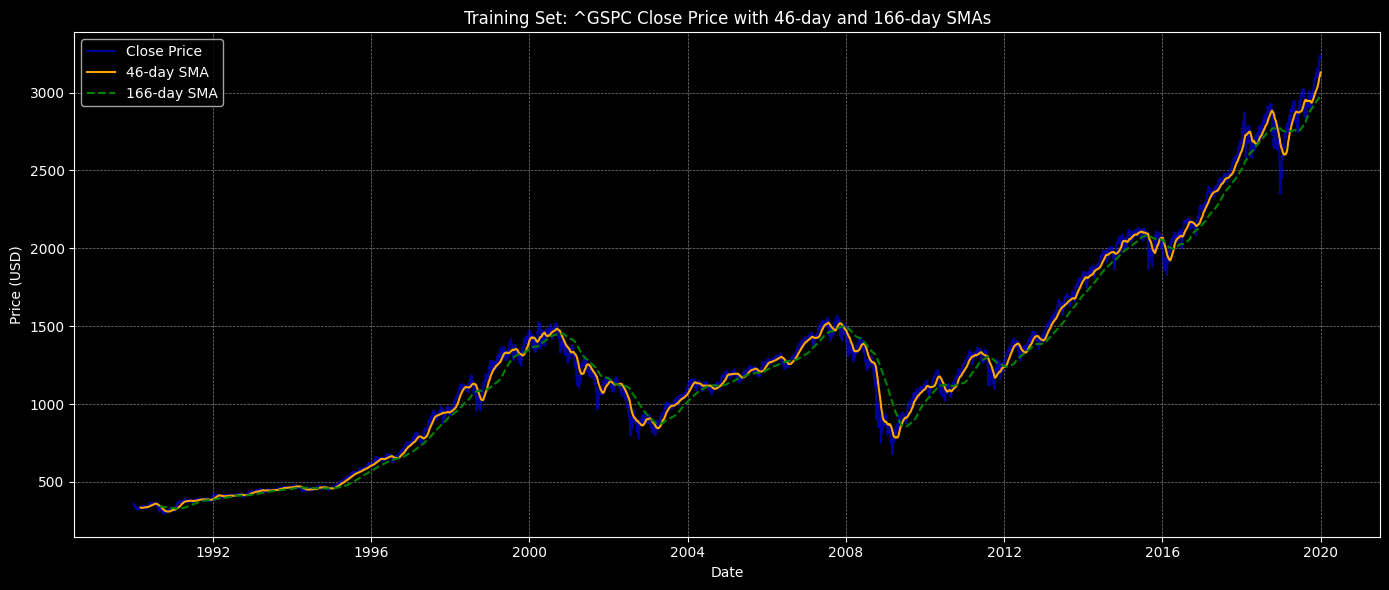

In [10]:
# Run backtest on training data with best short and long MA windows
_, _, df_train_result = backtest_strategy_double_ma(df_train, best_short_window, best_long_window, initial_capital)

# Plot Close price and the two moving averages (full dataset)
plt.figure(figsize=(14, 6))
plt.plot(df_train_result['Close'], label='Close Price', alpha=0.6, color='blue')
plt.plot(df_train_result['SMA_Short'], label=f'{best_short_window}-day SMA', color='orange', linestyle='-')
plt.plot(df_train_result['SMA_Long'], label=f'{best_long_window}-day SMA', color='green', linestyle='--')

# Chart formatting
plt.title(f"Training Set: {symbol} Close Price with {best_short_window}-day and {best_long_window}-day SMAs")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("training_set_sma_plot.png", dpi=300, bbox_inches='tight')
plt.show()

## Visualize Buy/Sell Signals on Test Data

In [11]:
final_value, trades, df_test_result = backtest_strategy_double_ma(
    df_test,
    best_short_window,
    best_long_window,
    initial_capital
)

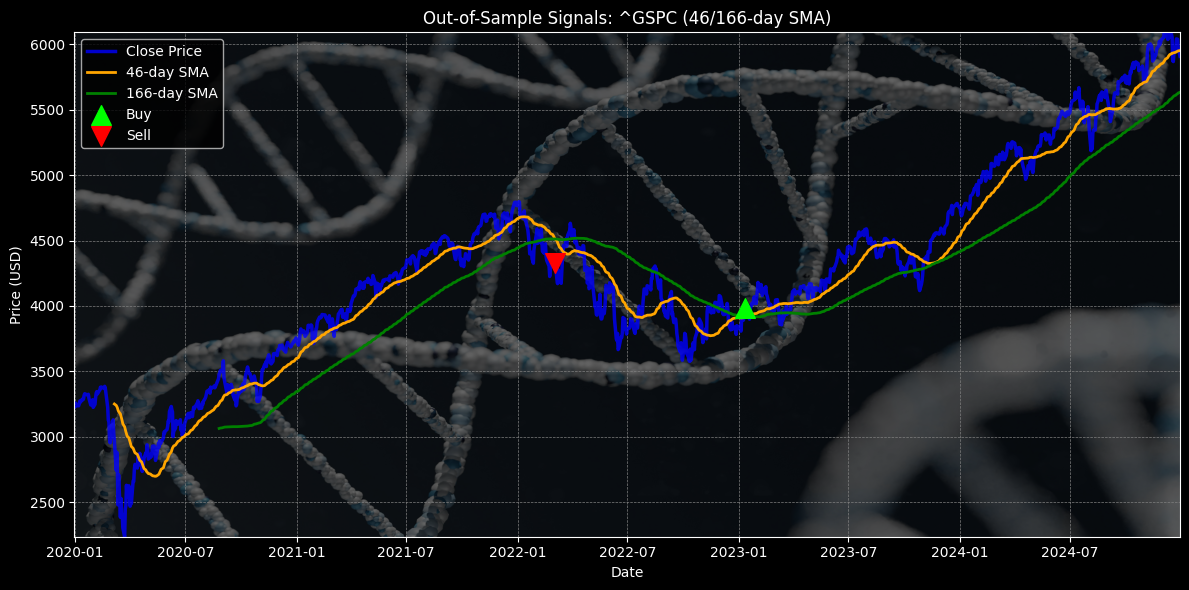

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df_test_result['Close'], label='Close Price', alpha=0.6, color='blue')
plt.plot(df_test_result['SMA_Short'], label=f'{best_short_window}-day SMA', color='orange')
plt.plot(df_test_result['SMA_Long'], label=f'{best_long_window}-day SMA', color='green')

# Identify buy signals: when short MA crosses above long MA
buy_signals = df_test_result[(df_test_result['SMA_Short'].shift(1) <= df_test_result['SMA_Long'].shift(1)) &
                             (df_test_result['SMA_Short'] > df_test_result['SMA_Long'])]

# Identify sell signals: when short MA crosses below long MA
sell_signals = df_test_result[(df_test_result['SMA_Short'].shift(1) >= df_test_result['SMA_Long'].shift(1)) &
                              (df_test_result['SMA_Short'] < df_test_result['SMA_Long'])]

# Plot buy/sell signals with enhancements
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='lime', s=120, label='Buy', zorder=5)
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', s=120, label='Sell', zorder=5)

plt.title(f"Out-of-Sample Signals: {symbol} ({best_short_window}/{best_long_window}-day SMA)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.savefig("out_of_sample_signals_plot.png", dpi=300, bbox_inches='tight')
plt.show()

## Compare Strategy vs Buy & Hold Perfomance

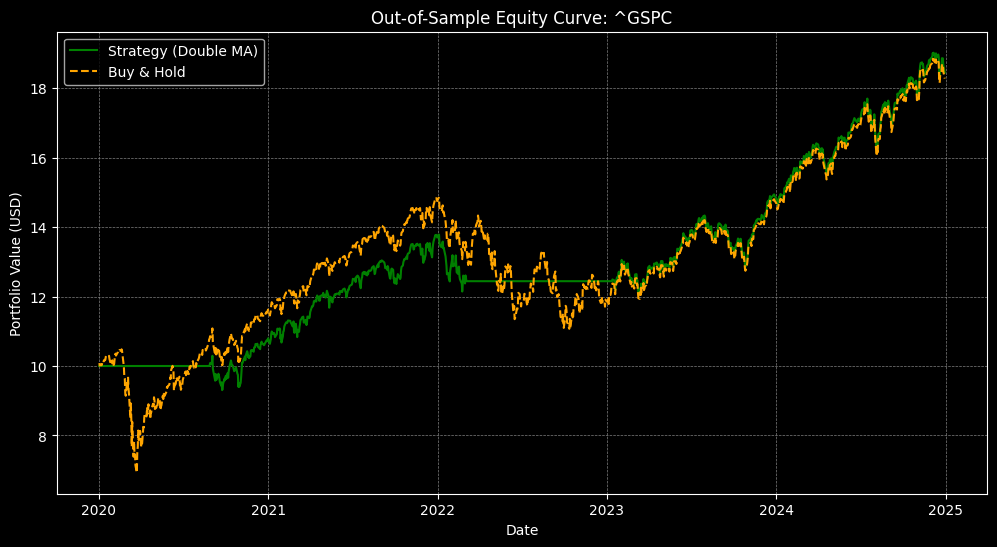

In [13]:
# Calculate Buy & Hold cumulative portfolio value
df_test_result['Buy & Hold'] = (1 + df_test_result['Return']).cumprod() * initial_capital

# Plot strategy equity curve vs buy & hold
plt.figure(figsize=(12, 6))
plt.plot(df_test_result['Equity Curve'], label='Strategy (Double MA)', color='green')
plt.plot(df_test_result['Buy & Hold'], label='Buy & Hold', linestyle='--', color='orange')

plt.title(f"Out-of-Sample Equity Curve: {symbol}")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (USD)")
plt.legend()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.savefig("equity_curve_plot.png", dpi=300, bbox_inches='tight')
plt.show()

## Final Perfomance Summary

In [14]:
final_strategy_value = df_test_result['Equity Curve'].iloc[-1]
final_bh_value = df_test_result['Buy & Hold'].iloc[-1]

strategy_return_pct = ((final_strategy_value / initial_capital) - 1) * 100
bh_return_pct = ((final_bh_value / initial_capital) - 1) * 100

summary = pd.DataFrame({
    "Metric": [
        "Optimized Short MA Window", 
        "Optimized Long MA Window", 
        "Final Strategy Value (Test)", 
        "Final Buy & Hold Value (Test)", 
        "Strategy Return (%)", 
        "Buy & Hold Return (%)", 
        "Number of Trades (Test)",
        "Average Time per Run (seconds)"
    ],
    "Value": [
        best_short_window, 
        best_long_window, 
        final_strategy_value, 
        final_bh_value, 
        strategy_return_pct, 
        bh_return_pct, 
        int(trades),
        average_time
    ]
}).set_index("Metric")

# Save summary to CSV
summary.to_csv("strategy_summary.csv")

summary

,Value
Metric,
Optimized Short MA Window,46.000000
Optimized Long MA Window,166.000000
Final Strategy Value (Test),18.453874
Final Buy & Hold Value (Test),18.283324
Strategy Return (%),84.538742
Buy & Hold Return (%),82.833244
Number of Trades (Test),3.000000
Average Time per Run (seconds),3.590756


## Monthly Return (Test Period)

C:\Users\Brian\AppData\Local\Temp\ipykernel_5900\3285103435.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  strategy_returns = df_test_result['Strategy Return'].resample('M').apply(lambda x: (1 + x).prod() - 1)
C:\Users\Brian\AppData\Local\Temp\ipykernel_5900\3285103435.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  buyhold_returns = df_test_result['Return'].resample('M').apply(lambda x: (1 + x).prod() - 1)


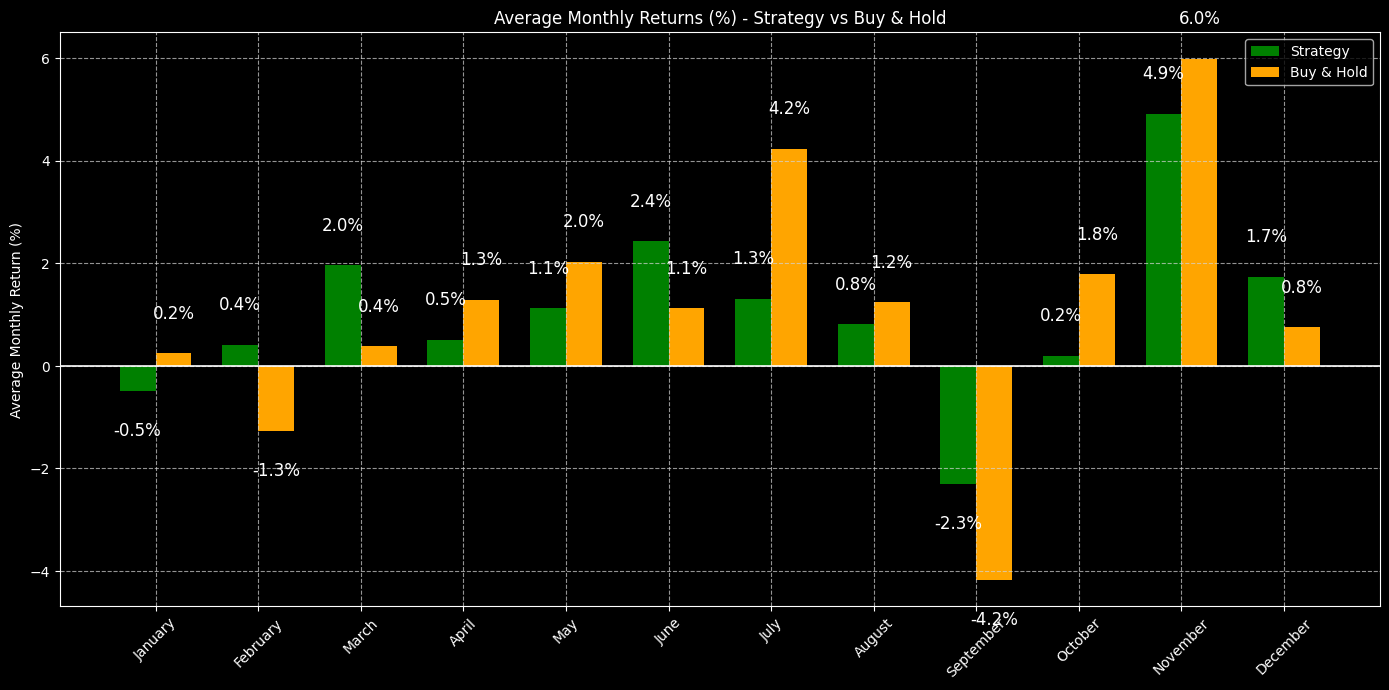

In [15]:
# Calculate monthly returns for strategy and buy & hold
strategy_returns = df_test_result['Strategy Return'].resample('M').apply(lambda x: (1 + x).prod() - 1)
buyhold_returns = df_test_result['Return'].resample('M').apply(lambda x: (1 + x).prod() - 1)

# Convert to DataFrame with Year and Month for strategy
strategy_df = strategy_returns.to_frame(name='Strategy Return')
strategy_df['Year'] = strategy_df.index.year
strategy_df['Month'] = strategy_df.index.month_name()

# Convert to DataFrame with Year and Month for buy & hold
buyhold_df = buyhold_returns.to_frame(name='Buy & Hold Return')
buyhold_df['Year'] = buyhold_df.index.year
buyhold_df['Month'] = buyhold_df.index.month_name()

# Compute average monthly returns across years
avg_strategy = strategy_df.groupby('Month')['Strategy Return'].mean()
avg_buyhold = buyhold_df.groupby('Month')['Buy & Hold Return'].mean()

# Order months Jan to Dec
month_order = list(calendar.month_name)[1:]
avg_strategy = avg_strategy.reindex(month_order) * 100  # convert to percentage
avg_buyhold = avg_buyhold.reindex(month_order) * 100    # convert to percentage

# Bar positions and width
x = np.arange(len(month_order))
width = 0.35

plt.figure(figsize=(14, 7))

# Plot bars for strategy and buy & hold returns
bars1 = plt.bar(x - width/2, avg_strategy, width, label='Strategy', color='green')
bars2 = plt.bar(x + width/2, avg_buyhold, width, label='Buy & Hold', color='orange')

# Horizontal zero line at y=0
plt.axhline(0, color='white', linewidth=1.2)

# Add both horizontal and vertical grid lines with light gray dashed style and opacity
plt.grid(axis='y', color='lightgray', linestyle='--', alpha=0.7)
plt.grid(axis='x', color='lightgray', linestyle='--', alpha=0.7)

# Annotate each bar with its value
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height >= 0:
            plt.text(bar.get_x() + bar.get_width() / 2, height + 0.6, f"{height:.1f}%", 
                     ha='center', va='bottom', fontsize=12)
        else:
            plt.text(bar.get_x() + bar.get_width() / 2, height - 0.6, f"{height:.1f}%", 
                     ha='center', va='top', fontsize=12)

# Set x-axis labels and rotation for readability
plt.xticks(x, month_order, rotation=45)

plt.ylabel('Average Monthly Return (%)')
plt.title('Average Monthly Returns (%) - Strategy vs Buy & Hold')
plt.legend()
plt.tight_layout()
plt.savefig("average_monthly_returns.png", dpi=300, bbox_inches='tight')
plt.show()